# ML from scratch: Stable Diffusion, Day 2

### [Binxu Wang](https://scholar.harvard.edu/binxuw) and [John Vastola](https://twitter.com/johnjvastola)

<p align="center">
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/astro.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/ballerina_chasing_cat.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/lovely_cat.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/turtle3.png?raw=true" alt="drawing" width="150"/>
</p>

On the first day, we went over the various components necessary to make an effective diffusion generative model like [Stable Diffusion](https://ommer-lab.com/research/latent-diffusion-models/). 

As a reminder, they are:

- Method of learning to generate new stuff (forward/reverse diffusion)
- Way to link text and images (text-image representation model like [CLIP](https://github.com/openai/CLIP))
- Way to compress images (autoencoder)
- Way to add in good inductive biases (U-net architecture + self/cross-attention)

In today's session, you will implement pieces of each of the above, and by the end have a working Stable-Diffusion-like model. 

In particular, you will implement parts of:

- **basic 1D forward/reverse diffusion**
- **a U-Net architecture for working with images**
- **the loss associated with learning the score function**
- **an attention model for conditional generation**
- **an autoencoder**

We need a reasonably small dataset so that training does not take forever, so we will be working with [MNIST](https://en.wikipedia.org/wiki/MNIST_database), a set of 28x28 images of handwritten 0-9 digits. By the end, our model should be able to take in a number prompt (e.g. "4") and output an image of the digit 4. 

----------------

In [ ]:
!pip install einops
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.6 MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

import matplotlib.pyplot as plt

from torchvision.utils import make_grid


-------------------------------------------

## 1. Basic forward/reverse diffusion 

This section reviews material from the [previous MLFS seminar](https://github.com/DrugowitschLab/ML-from-scratch-seminar/tree/master/DiffusionGenerativeModels) on diffusion generative models. Skip this if you already know the basics!

The gist is that our generative model will work in the following way. We will take our training examples (e.g. images) and corrupt them with noise until they are unrecognizable. Then we will learn to `denoise' them, and potentially turn pure noise into something similar to what we started with. 



### Basic forward diffusion

**Let's start with forward diffusion.** In the simplest case, the relevant diffusion equation is
\begin{equation}
\begin{split}
x(t + \Delta t) = x(t) + \sigma(t) \sqrt{\Delta t} \ r
\end{split}
\end{equation}
where $\sigma(t) > 0$ is the 'noise strength', $\Delta t$ is the step size, and $r \sim \mathcal{N}(0, 1)$ is a standard normal random variable. In essence, we repeatedly add normally-distributed noise to our sample. Often, the noise strength $\sigma(t)$ is chosen to depend on time (i.e. it gets higher as $t$ gets larger).

**Implement the missing part of 1D forward diffusion**.

*Hint: You can use `np.random.randn()` to generate random numbers.*

In [ ]:
# Simulate forward diffusion for N steps.
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
  """x0: initial sample value, scalar
  noise_strength_fn: function of time, outputs scalar noise strength
  t0: initial time
  nsteps: number of diffusion steps
  dt: time step size
  """

  # Initialize trajectory
  x = np.zeros(nsteps + 1); x[0] = x0
  t = t0 + np.arange(nsteps + 1)*dt 
  
  # Perform many Euler-Maruyama time steps
  for i in range(nsteps):
    noise_strength = noise_strength_fn(t[i])
    ############ YOUR CODE HERE (2 lines)
    random_normal = ...
    x[i+1] = ...
    #####################################
  return x, t


# Example noise strength function: always equal to 1
def noise_strength_constant(t):
  return 1

See if it works by running the code below.

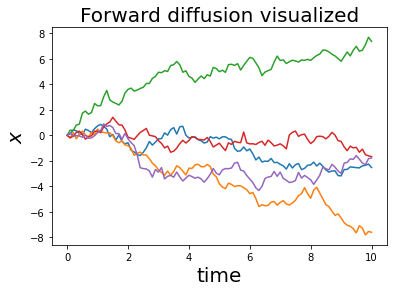

In [ ]:
nsteps = 100
t0 = 0
dt = 0.1
noise_strength_fn = noise_strength_constant
x0 = 0

num_tries = 5
for i in range(num_tries):
  x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)
  
  plt.plot(t, x)
  plt.xlabel('time', fontsize=20)
  plt.ylabel('$x$', fontsize=20)
plt.title('Forward diffusion visualized', fontsize=20)
plt.show()

### Basic reverse diffusion

We can reverse this diffusion process by a similar-looking update rule:
\begin{equation}
x(t + \Delta t) = x(t) + \sigma(T - t)^2 \frac{d}{dx}\left[ \log p(x, T-t) \right] \Delta t + \sigma(T-t) \sqrt{\Delta t} \ r
\end{equation}
where
\begin{equation}
s(x, t) := \frac{d}{dx} \log p(x, t)
\end{equation}
is called the **score function**. If we know this function, we can reverse the forward diffusion and turn noise into what we started with.

If our initial sample is always just one point at $x_0 = 0$, and the noise strength is constant, then the score function is exactly equal to
\begin{equation}
s(x, t) = - \frac{(x - x_0)}{\sigma^2 t} = - \frac{x}{\sigma^2 t} \ .
\end{equation}

**Implement the missing part of 1D reverse diffusion**. You will test it with the above score function.

*Hint: You can use `np.random.randn()` to generate random numbers.*

In [ ]:
# Simulate forward diffusion for N steps.
def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
  """x0: initial sample value, scalar
  noise_strength_fn: function of time, outputs scalar noise strength
  score_fn: score function
  T: final time
  nsteps: number of diffusion steps
  dt: time step size
  """

  # Initialize trajectory
  x = np.zeros(nsteps + 1); x[0] = x0
  t = np.arange(nsteps + 1)*dt 
  
  # Perform many Euler-Maruyama time steps
  for i in range(nsteps):
    noise_strength = noise_strength_fn(T - t[i])
    score = score_fn(x[i], 0, noise_strength, T-t[i])
    ############ YOUR CODE HERE (2 lines)
    random_normal = ...
    x[i+1] = ...
    #####################################
  return x, t


# Example noise strength function: always equal to 1
def score_simple(x, x0, noise_strength, t):
  score = - (x-x0)/((noise_strength**2)*t)
  return score

Run the cell below to see if your implementation works.

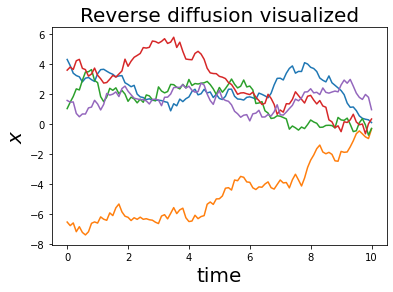

In [ ]:
nsteps = 100
t0 = 0
dt = 0.1
noise_strength_fn = noise_strength_constant
score_fn = score_simple
x0 = 0
T = 11


num_tries = 5
for i in range(num_tries):
  x0 = np.random.normal(loc=0, scale=T)   # draw from the noise distribution, which is diffusion for time T w noise strength 1
  x, t = reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt)
  
  plt.plot(t, x)
  plt.xlabel('time', fontsize=20)
  plt.ylabel('$x$', fontsize=20)
plt.title('Reverse diffusion visualized', fontsize=20)
plt.show()

### Basic score function learning

In practice, we don't already know the score function; instead, we have to learn it. One way to learn it is to train a neural network to `denoise' samples via the denoising objective
\begin{equation}
J := \mathbb{E}_{t\in (0, T), x_0 \sim p_0(x_0)}\left[ \ \Vert s(x_{noised}, t) \sigma^2(t) + (x_{noised} - x_0)  \Vert^2_2  \ \right]
\end{equation}
where $p_0(x_0)$ is our target distribution (e.g. pictures of cats and dogs), and where $x_{noised}$ is the target distribution sample $x_0$ after one forward diffusion step, i.e. $x_{noised} - x_0$ is just a normally-distributed random variable.

Here's another way of writing the same thing, which is closer to the actual implementation. By substituting
\begin{equation}
x_{noised} = x_0 + \sigma(t) \epsilon, \; \epsilon\sim \mathcal N(0,I)
\end{equation}
We got this objective function
\begin{equation}
J := \mathbb{E}_{t\in (0, T), x_0 \sim p_0(x_0), \epsilon \sim \mathcal N(0,I)}\left[ \ \Vert s(x_0 + \sigma(t) \epsilon, t) \sigma(t) + \epsilon  \Vert^2_2  \ \right]
\end{equation}
We will implement this for you. But it's good to understand the intuition: we are learning to predict **how much noise was added to each part of our sample**. We should be able to do this well at every time $t$ in the diffusion process, and for every $x_0$ in our original (dogs/cats/etc) distribution.

---------------------

## 2. Working with images via U-Nets

We just reviewed the very basics of diffusion models, with the takeaway that learning the score function allows us to turn pure noise into something interesting. We will learn to approximate the score function with a neural network. But when we are working with images, we need our neural network to 'play nice' with them, and to reflect inductive biases we associate with images.

A reasonable choice is to choose the neural network architecture to be that of a [U-Net](https://en.wikipedia.org/wiki/U-Net), which combines a CNN-like structure with downscaling/upscaling operations that help the network pay attention to features of images at different spatial scales.  

Since the score function we're trying to learn is a function of time, we also need to come up with a way to make sure our neural network properly responds to changes in time. For this purpose, we can use a **time embedding**.

In this section, **you will fill in some missing U-Net pieces.** 

### Helping our neural network work with time

The below code helps our neural network work with time via a **time embedding**. The idea is that, instead of just telling our network one number (the current time), we express the current time in terms of a large number of sinusoidal features. The hope is that, if we tell our network the current time in many different ways, it will more easily respond to changes in time.

This will enable us to successfully learn a time-dependent score function $s(x, t)$. 

In [ ]:
#@title Get some modules to let time interact

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights (frequencies) during initialization. 
    # These weights (frequencies) are fixed during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None] 
    # this broadcast the 2d tensor to 4d, add the same value across space. 


### Defining the U-Net architecture

The below class defines a U-Net architecture. **Fill in the missing pieces.** (This shouldn't be hard; mainly, it's to get you to look at the structure.)

In [ ]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

class UNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
          GaussianFourierProjection(embed_dim=embed_dim),
          nn.Linear(embed_dim, embed_dim)
          )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    
    ########### YOUR CODE HERE (3 lines)
    self.conv3 = ...
    self.dense3 = ...
    self.gnorm3 = ...
    #########################
    
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])   
     

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t, y=None): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.time_embed(t))    
    # Encoding path
    h1 = self.conv1(x)  + self.dense1(embed)   
    ## Incorporate information from t
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    ########## YOUR CODE HERE (2 lines)
    h3 = ...    # conv, dense
    #   apply activation function
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    ############
    h4 = self.conv4(h3) + self.dense4(embed)
    h4 = self.act(self.gnorm4(h4))

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

Below is code for an alternate U-Net architecture. Apparently, diffusion models can be successful with somewhat different architectural details. (Note that the differences from the above class are kind of subtle, though.)

* Upper one, **concatenate the tensor from the down block** for skip connection. 
* Lower one, directly **add the tensor from the down blocks** for skip connection. 
  * A special case of the upper

In [ ]:
#@title Alternative time-dependent score-based model (double click to expand or collapse)

class UNet_res(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
          GaussianFourierProjection(embed_dim=embed_dim),
          nn.Linear(embed_dim, embed_dim)
          )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     #  + channels[2]
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)     #  + channels[1]
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1) #  + channels[0]
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t, y=None): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.time_embed(t))    
    # Encoding path
    h1 = self.conv1(x)  + self.dense1(embed)   
    ## Incorporate information from t
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    h4 = self.conv4(h3) + self.dense4(embed)
    h4 = self.act(self.gnorm4(h4))

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(h + h3)
    h += self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(h + h2)
    h += self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(h + h1)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

**Tips**: When you feel uncertain about the shape of the tensors throughout the layers, define the layers outside and see the shapes. This format could be helpful. 

In [ ]:
net = nn.Sequential(
    nn.Conv2d(...),
    nn.ConvTranspose2d(...),
)
x = torch.randn(...)
for l in net:
    x = layer(x)
    print(x.shape)

----------------

## 3. Train the U-Net to learn a score function

Let's combine the U-Net we just defined with a way to learn the score function. We need to define a loss function, and then train a neural network in the usual way.

In the next cell, we will define the specific forward diffusion process 
$$
dx = \sigma^t dw
$$
the "diffusion constant" $\sigma^t$ adds noise to $x$ samples with exponentially increasing noise scale. 

Given this forward process, and given a starting $x(0)$ we have an analytically solution for the sample at any time $x(t)$
$$
p(x(t)|x(0))=\mathcal N(x(0),\sigma(t)^2)
$$
We call $\sigma(t)$ the marginal std, i.e. the standard deviation of the conditional distribution. In this specific case, 
$$
\sigma^2(t)=\int_0^t (\sigma^\tau ) ^2d\tau = \int_0^t \sigma^{2\tau} d\tau = \frac{\sigma^{2t}-1}{2\log \sigma }
$$

In [ ]:
#@title Diffusion constant and noise strength
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

### Defining the loss function

The loss function is mostly defined below. **You need to add one part**: sample random noise with strength `std[:, None, None, None]`, and make sure it has the same shape as $\mathbf{x}$. Then use this to perturb $\mathbf{x}$.

*Hint: `torch.randn_like()` may be useful.*

In [ ]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  # Sample time uniformly in 0, 1
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps 
  # Find the noise std at the time `t`
  std = marginal_prob_std(random_t)
  ####### YOUR CODE HERE  (2 lines)
  z = ...             # get normally distributed noise
  perturbed_x = x + ...
  ##############
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

### Defining the sampler

In [ ]:
#@title Sampler code
num_steps = 500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
              marginal_prob_std,
              diffusion_coeff, 
              batch_size=64, 
              x_shape=(1, 28, 28),
              num_steps=num_steps, 
              device='cuda', 
              eps=1e-3, y=None):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, *x_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

### Training on MNIST

We will train on MNIST, and learn to generate pictures that look like 0-9 digits. No code to fill in here; just run it and see if it works!

In the following code, the loss could descent to ~ 40-50. 

In [ ]:
#@title Training (double click to expand or collapse)

score_model = torch.nn.DataParallel(UNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  2048 #@param {'type':'integer'}
## learning rate
lr=5e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in tqdm(data_loader):
    x = x.to(device)    
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

In the following code, the loss could descent to ~ 25, with relatively good quality. 

In [ ]:
#@title Training the alternate U-Net model (double click to expand or collapse)

score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   75#@param {'type':'integer'}
## size of a mini-batch
batch_size =  1024 #@param {'type':'integer'}
## learning rate
lr=10e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)    
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  scheduler.step()
  lr_current = scheduler.get_last_lr()[0]
  print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt_res.pth')

  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0 Average Loss: 1070.723943 lr 9.8e-04
1 Average Loss: 312.869164 lr 9.6e-04
2 Average Loss: 209.593512 lr 9.4e-04
3 Average Loss: 159.604592 lr 9.2e-04
4 Average Loss: 131.208202 lr 9.0e-04
5 Average Loss: 112.011338 lr 8.9e-04
6 Average Loss: 99.231037 lr 8.7e-04
7 Average Loss: 89.299207 lr 8.5e-04
8 Average Loss: 81.803251 lr 8.3e-04
9 Average Loss: 75.683446 lr 8.2e-04
10 Average Loss: 70.674667 lr 8.0e-04
11 Average Loss: 66.624008 lr 7.8e-04
12 Average Loss: 62.762296 lr 7.7e-04
13 Average Loss: 59.316022 lr 7.5e-04
14 Average Loss: 56.370946 lr 7.4e-04
15 Average Loss: 54.499845 lr 7.2e-04
16 Average Loss: 51.994298 lr 7.1e-04
17 Average Loss: 49.876137 lr 7.0e-04
18 Average Loss: 48.393268 lr 6.8e-04
19 Average Loss: 46.500402 lr 6.7e-04
20 Average Loss: 45.150150 lr 6.5e-04
21 Average Loss: 43.693895 lr 6.4e-04
22 Average Loss: 42.697722 lr 6.3e-04
23 Average Loss: 41.578316 lr 6.2e-04
24 Average Loss: 40.365930 lr 6.0e-04
25 Average Loss: 39.272062 lr 5.9e-04
26 Average Loss

Visualize the results of training below.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


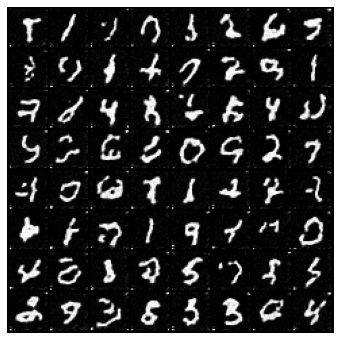

In [ ]:

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
# ckpt = torch.load('ckpt.pth', map_location=device)
# score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
num_steps = 500 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model, 
          marginal_prob_std_fn,
          diffusion_coeff_fn, 
          sample_batch_size, 
          num_steps=num_steps,
          device=device,
          y=None)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


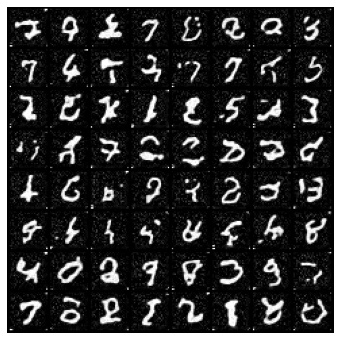

In [ ]:
def save_samples_uncond(score_model, suffix=""):
  score_model.eval()
  ## Generate samples using the specified sampler.
  sample_batch_size = 64 #@param {'type':'integer'}
  num_steps = 250 #@param {'type':'integer'}
  sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
  # score_model.eval()
  ## Generate samples using the specified sampler.
  samples = sampler(score_model, 
          marginal_prob_std_fn,
          diffusion_coeff_fn, 
          sample_batch_size, 
          num_steps=num_steps,
          device=device,
          )

      ## Sample visualization.
  samples = samples.clamp(0.0, 1.0)
  sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))
  sample_np = sample_grid.permute(1, 2, 0).cpu().numpy()
  plt.imsave(f"uncondition_diffusion{suffix}.png", sample_np,)
  plt.figure(figsize=(6,6))
  plt.axis('off')
  plt.imshow(sample_np, vmin=0., vmax=1.)
  plt.show()

uncond_score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
uncond_score_model.load_state_dict(torch.load("ckpt_res.pth"))
save_samples_uncond(uncond_score_model, suffix="_res")

----------------------

## 4. Using attention to get conditional generation to work

In addition to generating images of e.g. 0-9 digits, we would like to do *conditional* generation: we would like to *specify* which digit we would like to generate an image of, for example. 

Attention models, while not strictly necessary for conditional generation, have proven useful for getting it to work well. In this section, you will implement parts of an attention model.

In [ ]:
from einops import rearrange
import math

### "Word embedding" of digits

Here, instead of using a fancy CLIP model, we just define our own vector representations of the digits 0-9. 

We used the `nn.Embedding` layer to turn 0-9 index into vectors. 

In [ ]:
class WordEmbed(nn.Module):
  def __init__(self, vocab_size, embed_dim):
    super(WordEmbed, self).__init__()
    self.embed = nn.Embedding(vocab_size+1, embed_dim)
  
  def forward(self, ids):
    return self.embed(ids)

### Let's develop our Attention layer

We usually implement attention models using 3 parts:
* `CrossAttention`  Write a module to do self / cross attention for **sequences**. 
* `TransformerBlock`  Combine self/cross-attention and a feed-forward neural network. 
* `SpatialTransformer`  To use attention in a U-net, transform the spatial tensor to a sequential tensor and back. 

**You will implement a part of the CrossAttention class**, and you will also pick where to add attention in your U-Net.

<p align="center">
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/attention_pic1.png?raw=true" alt="drawing" width="850"/>
</p>

Here's a brief review of the mathematics of attention models. [QKV (query-key-value) attention models](https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms) represent queries, keys, and values as vectors. These are tools that help us relate words/images on one side of a translation task to the other side.

These are linearly related to $\mathbf{e}$ vectors (which represent the hidden state of the encoder) and $\mathbf{h}$ vectors (which represent the hidden state of the decoder):

\begin{equation}
\begin{split}
\mathbf{q}_i &= W_q \mathbf{h}_i \\
\mathbf{k}_j &= W_k \mathbf{e}_j \\
\mathbf{v}_j &= W_v \mathbf{e}_j \ .
\end{split}
\end{equation}

To figure out what to 'pay attention' to, we compute the inner product (i.e. similarity) of each key $\mathbf{k}$ and query $\mathbf{q}$. To get typical values that are not too big or too small, we normalize by the length/dimension of the query vectors $\mathbf{q}_i$. 

The final attention distribution comes from softmax-ing all of this:

\begin{equation}
\begin{split}
a_{ij} &= \text{SoftMax}\left( \frac{\mathbf{k}_j \cdot \mathbf{q}_i}{\sqrt{\text{len}(\mathbf{q}_i)}} \right) \\
\sum_j a_{ij} &= 1 
\end{split}
\end{equation}

The attention distribution is used to pick out some relevant combination of features. For example, in translating the phrase "European Union" from English to French, getting the correct answer ("Union européenne") requires paying attention to both words at once, instead of trying to translate each word totally separately. Mathematically, we weight values $\mathbf{v}_j$ by the attention distribution:

\begin{equation}
\mathbf{c}_i := \sum_j a_{ij} \mathbf{v}_j
\end{equation}

**Implement the missing pieces of the CrossAttention class below. Also implement the missing part of the TransformerBlock class.**

Note that the relevant matrix multiplications can be performed using `torch.einsum`. For example, to multiply an $M \times N$ matrix $A$ together with an $N \times N$ matrix $B$, i.e. to obtain $A B$, we can write:

`torch.einsum(ij,jk -> ik ,A, B)`

If, instead, we wanted to compute $A B^T$, we could write

`torch.einsum(ij,kj->ik ,A, B)`

The library takes care of moving the dimensions around properly. For machine learning, it is often important to do operations like matrix multiplication in batches. In this case, you can might have tensors instead of matrices, but you can write a very similar expression:

`torch.einsum(bij,bkj ,A, B)`

where `b` here is the index that describes which batch elements we are talking about. As a final point, you can use whatever letters you like instead of `i`, `j`, etc.

*Hint: `F.softmax` may also be helpful!*

### Attention Modules

In [ ]:
class CrossAttention(nn.Module):
  def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1,):
    """
    Note: For simplicity reason, we just implemented 1-head attention. 
    Feel free to implement multi-head attention! with fancy tensor manipulations.
    """
    super(CrossAttention, self).__init__()
    self.hidden_dim = hidden_dim
    self.context_dim = context_dim
    self.embed_dim = embed_dim
    self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
    if context_dim is None:
      self.self_attn = True 
      self.key = nn.Linear(hidden_dim, embed_dim, bias=False)     ###########
      self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)  ############
    else:
      self.self_attn = False 
      self.key = nn.Linear(context_dim, embed_dim, bias=False)   #############
      self.value = nn.Linear(context_dim, hidden_dim, bias=False) ############
    
    
  def forward(self, tokens, context=None):
    # tokens: with shape [batch, sequence_len, hidden_dim]
    # context: with shape [batch, contex_seq_len, context_dim]
    if self.self_attn:
        Q = self.query(tokens)
        K = self.key(tokens)  
        V = self.value(tokens) 
    else:
        # implement Q, K, V for the Cross attention 
        Q = ...
        K = ...
        V = ...
    #print(Q.shape, K.shape, V.shape)
    ####### YOUR CODE HERE (2 lines)
    scoremats = ...         # inner product of Q and K, a tensor 
    attnmats = ...          # softmax of scoremats
    #print(scoremats.shape, attnmats.shape, )
    ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # weighted average value vectors by attnmats
    return ctx_vecs


class TransformerBlock(nn.Module):
  """The transformer block that combines self-attn, cross-attn and feed forward neural net"""
  def __init__(self, hidden_dim, context_dim):
    super(TransformerBlock, self).__init__()
    self.attn_self = CrossAttention(hidden_dim, hidden_dim, )
    self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

    self.norm1 = nn.LayerNorm(hidden_dim)
    self.norm2 = nn.LayerNorm(hidden_dim)
    self.norm3 = nn.LayerNorm(hidden_dim)
    # implement a 2 layer MLP with K*hidden_dim hidden units, and nn.GeLU nonlinearity #######
    self.ffn  = nn.Sequential(
        # YOUR CODE HERE ##################
        ...
    )
    
  def forward(self, x, context=None):
    # Notice the + x as residue connections
    x = self.attn_self(self.norm1(x)) + x
    # Notice the + x as residue connections
    x = self.attn_cross(self.norm2(x), context=context) + x
    # Notice the + x as residue connections
    x = self.ffn(self.norm3(x)) + x
    return x 

class SpatialTransformer(nn.Module):
  def __init__(self, hidden_dim, context_dim):
    super(SpatialTransformer, self).__init__()
    self.transformer = TransformerBlock(hidden_dim, context_dim)

  def forward(self, x, context=None):
    b, c, h, w = x.shape
    x_in = x
    # Combine the spatial dimensions and move the channel dimen to the end
    x = rearrange(x, "b c h w->b (h w) c")
    # Apply the sequence transformer
    x = self.transformer(x, context)
    # Reverse the process
    x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
    # Residue 
    return x + x_in

Code play ground!

### Putting it together, UNet Transformer

Now you can interleave your `SpatialTransformer` layers with the convolutional layers! 

Remember to use them in your forward function. **Look at the architecture, and add in extra attention layers if you wish.**

In [ ]:
class UNet_Tranformer(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256, 
               text_dim=256, nClass=10):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings of time.
      text_dim:  the embedding dimension of text / digits. 
      nClass:    number of classes you want to model.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim)
        )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.attn3 = SpatialTransformer(channels[2], text_dim) 
    
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    
    # YOUR CODE: interleave some attention layers with conv layers
    self.attn4 = ...                        ######################################

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])   

    self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     #  + channels[2]
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    
    self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)     #  + channels[1]
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1) #  + channels[0]
    
    # The swish activation function
    self.act = nn.SiLU() # lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
    self.cond_embed = nn.Embedding(nClass, text_dim)
  
  def forward(self, x, t, y=None): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.time_embed(t))    
    y_embed = self.cond_embed(y).unsqueeze(1)
    # Encoding path
    h1 = self.conv1(x) + self.dense1(embed) 
    ## Incorporate information from t
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    h3 = self.attn3(h3, y_embed) # Use your attention layers
    h4 = self.conv4(h3) + self.dense4(embed)
    h4 = self.act(self.gnorm4(h4))
    # Your code: Use your additional attention layers! 
    h4 = ...       ##################### ATTENTION LAYER COULD GO HERE IF ATTN4 IS DEFINED

    # Decoding path
    h = self.tconv4(h4) + self.dense5(embed)
    ## Skip connection from the encoding path
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(h + h3) + self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(h + h2) + self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(h + h1)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

### Conditional Denoising Loss

Here, we need to modify the loss function by using the `y` information in the training. 

In [ ]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t, y=y)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

### Training a model that includes attention

The below code, similar to code above, does the training.

In [ ]:
#@title Training model

continue_training = False #@param {type:"boolean"}
if not continue_training:
  print("initilize new score model...")
  score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
  score_model = score_model.to(device)


n_epochs =   100#@param {'type':'integer'}
## size of a mini-batch
batch_size =  1024 #@param {'type':'integer'}
## learning rate
lr=10e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in tqdm(data_loader):
    x = x.to(device)    
    loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  scheduler.step()
  lr_current = scheduler.get_last_lr()[0]
  print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt_transformer.pth')

initilize new score model...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0 Average Loss: 911.835488 lr 9.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

1 Average Loss: 247.529141 lr 9.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

2 Average Loss: 159.000987 lr 9.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

3 Average Loss: 117.500008 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

4 Average Loss: 93.430158 lr 9.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

5 Average Loss: 79.269252 lr 8.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

6 Average Loss: 69.451496 lr 8.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

7 Average Loss: 62.244141 lr 8.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

8 Average Loss: 56.955125 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

9 Average Loss: 51.763428 lr 8.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

10 Average Loss: 48.633911 lr 8.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

11 Average Loss: 46.004020 lr 7.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

12 Average Loss: 44.236268 lr 7.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

13 Average Loss: 42.072793 lr 7.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

14 Average Loss: 40.703189 lr 7.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

15 Average Loss: 39.530541 lr 7.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

16 Average Loss: 38.568226 lr 7.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

17 Average Loss: 37.374072 lr 7.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

18 Average Loss: 36.376193 lr 6.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

19 Average Loss: 35.763268 lr 6.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

20 Average Loss: 35.203006 lr 6.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

21 Average Loss: 34.426941 lr 6.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

22 Average Loss: 33.771495 lr 6.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

23 Average Loss: 33.430943 lr 6.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

24 Average Loss: 33.097876 lr 6.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

25 Average Loss: 32.334015 lr 5.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

26 Average Loss: 32.121282 lr 5.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

27 Average Loss: 31.700731 lr 5.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

28 Average Loss: 31.240735 lr 5.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

29 Average Loss: 31.116556 lr 5.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

30 Average Loss: 30.213783 lr 5.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

31 Average Loss: 30.142528 lr 5.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

32 Average Loss: 29.572817 lr 5.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

33 Average Loss: 29.405506 lr 5.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

34 Average Loss: 28.913737 lr 4.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

35 Average Loss: 29.124497 lr 4.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

36 Average Loss: 28.703883 lr 4.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

37 Average Loss: 28.425991 lr 4.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

38 Average Loss: 28.084901 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

39 Average Loss: 27.986393 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

40 Average Loss: 27.545136 lr 4.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

41 Average Loss: 27.341096 lr 4.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

42 Average Loss: 27.178352 lr 4.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

43 Average Loss: 27.105629 lr 4.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

44 Average Loss: 26.826516 lr 4.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

45 Average Loss: 26.458968 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

46 Average Loss: 26.755344 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

47 Average Loss: 26.361928 lr 3.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

48 Average Loss: 25.903759 lr 3.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

49 Average Loss: 26.234516 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

50 Average Loss: 25.775030 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

51 Average Loss: 25.525633 lr 3.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

52 Average Loss: 25.677089 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

53 Average Loss: 25.267192 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

54 Average Loss: 25.461929 lr 3.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

55 Average Loss: 25.184782 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

56 Average Loss: 24.780046 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

57 Average Loss: 24.718920 lr 3.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

58 Average Loss: 24.864525 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

59 Average Loss: 24.542736 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

60 Average Loss: 24.552311 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

61 Average Loss: 24.430597 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

62 Average Loss: 24.046150 lr 2.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

63 Average Loss: 23.895412 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

64 Average Loss: 23.895568 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

65 Average Loss: 24.022242 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

66 Average Loss: 23.582576 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

67 Average Loss: 23.530880 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

68 Average Loss: 23.764094 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

69 Average Loss: 23.642832 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

70 Average Loss: 23.571634 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

71 Average Loss: 23.427607 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

72 Average Loss: 23.303141 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

73 Average Loss: 23.363988 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

74 Average Loss: 23.228841 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

75 Average Loss: 23.210248 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

76 Average Loss: 22.962327 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

77 Average Loss: 22.764237 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

78 Average Loss: 22.771735 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

79 Average Loss: 22.673690 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

80 Average Loss: 22.459341 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

81 Average Loss: 22.565987 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

82 Average Loss: 22.460520 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

83 Average Loss: 22.582685 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

84 Average Loss: 22.532176 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

85 Average Loss: 22.255016 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

86 Average Loss: 22.438315 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

87 Average Loss: 22.113862 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

88 Average Loss: 22.139238 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

89 Average Loss: 22.073406 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

90 Average Loss: 21.951703 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

91 Average Loss: 22.078716 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

92 Average Loss: 21.877473 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

93 Average Loss: 21.665942 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

94 Average Loss: 21.745823 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

95 Average Loss: 21.626989 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

96 Average Loss: 21.624281 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

97 Average Loss: 21.708963 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

98 Average Loss: 21.351878 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

99 Average Loss: 21.622979 lr 2.0e-04


Loss around 23 at 67 epochs (without lr tuning, around 150 epochs reach 23)

In [ ]:
#@title A handy training function
def train_diffusion_model(dataset,
                          score_model,
                          n_epochs =   100,
                          batch_size =  1024,
                          lr=10e-4,
                          model_name="transformer"):

  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

  optimizer = Adam(score_model.parameters(), lr=lr)
  scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
  tqdm_epoch = trange(n_epochs)
  for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, y in tqdm(data_loader):
      x = x.to(device)    
      loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
      optimizer.zero_grad()
      loss.backward()    
      optimizer.step()
      avg_loss += loss.item() * x.shape[0]
      num_items += x.shape[0]
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), f'ckpt_{model_name}.pth')

In [ ]:
# Feel free to play with hyperparameters for training!
score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
train_diffusion_model(dataset, score_model,
                      n_epochs =   100,
                      batch_size =  1024,
                      lr=10e-4,
                      model_name="transformer")

In [ ]:

def visualize_digit_embedding(digit_embed):
  cossim_mat = []
  for i in range(10):
    cossim = torch.cosine_similarity(digit_embed, digit_embed[i:i+1,:]).cpu()
    cossim_mat.append(cossim)
  cossim_mat = torch.stack(cossim_mat)
  cossim_mat_nodiag = cossim_mat + torch.diag_embed(torch.nan * torch.ones(10))
  plt.imshow(cossim_mat_nodiag)
  plt.show()
  return cossim_mat

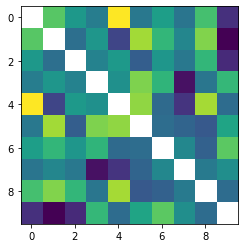

In [ ]:
cossim_mat = visualize_digit_embedding(score_model.module.cond_embed.weight.data)

### Examine Samples

Here is some code we can use to see how well the model does conditional generation. You can use the menu on the right to choose what you want to generate.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


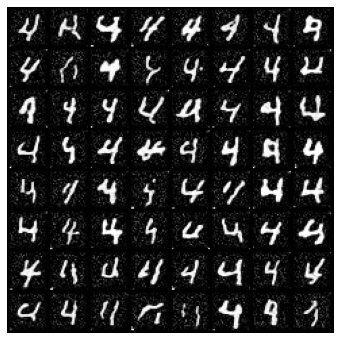

In [ ]:
## Load the pre-trained checkpoint from disk.
# device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
# ckpt = torch.load('ckpt.pth', map_location=device)
# score_model.load_state_dict(ckpt)
digit = 4 #@param {'type':'integer'}
sample_batch_size = 64 #@param {'type':'integer'}
num_steps = 250 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
# score_model.eval()
## Generate samples using the specified sampler.
samples = sampler(score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size, 
        num_steps=num_steps,
        device=device,
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [ ]:
def save_samples_cond(score_model, suffix):
  score_model.eval()
  for digit in range(10):
    ## Generate samples using the specified sampler.
    sample_batch_size = 64 #@param {'type':'integer'}
    num_steps = 500 #@param {'type':'integer'}
    sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
    # score_model.eval()
    ## Generate samples using the specified sampler.
    samples = sampler(score_model, 
            marginal_prob_std_fn,
            diffusion_coeff_fn, 
            sample_batch_size, 
            num_steps=num_steps,
            device=device,
            y=digit*torch.ones(sample_batch_size, dtype=torch.long))

        ## Sample visualization.
    samples = samples.clamp(0.0, 1.0)
    sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))
    sample_np = sample_grid.permute(1, 2, 0).cpu().numpy()
    plt.imsave(f"condition_diffusion{suffix}_digit%d.png"%digit, sample_np,)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_np, vmin=0., vmax=1.)
    plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


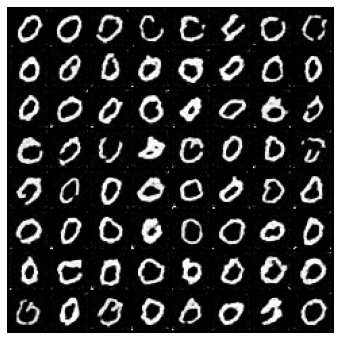

  0%|          | 0/500 [00:00<?, ?it/s]

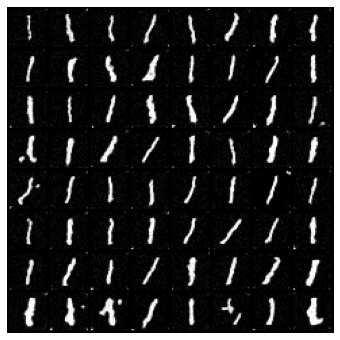

  0%|          | 0/500 [00:00<?, ?it/s]

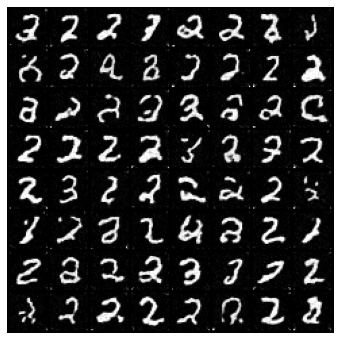

  0%|          | 0/500 [00:00<?, ?it/s]

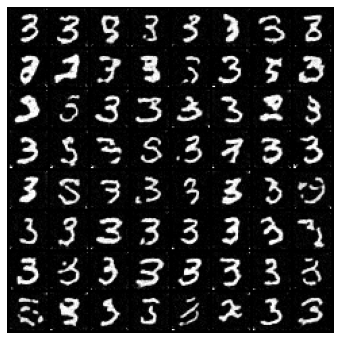

  0%|          | 0/500 [00:00<?, ?it/s]

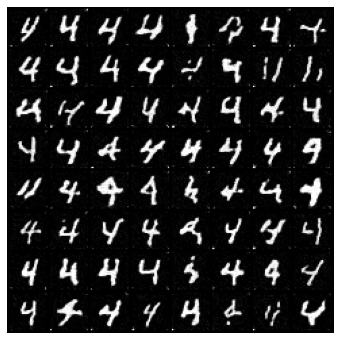

  0%|          | 0/500 [00:00<?, ?it/s]

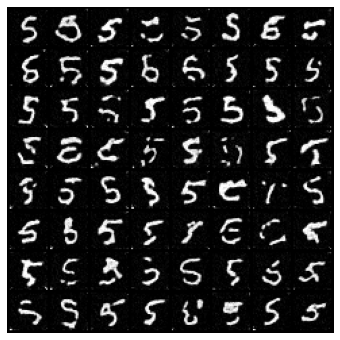

  0%|          | 0/500 [00:00<?, ?it/s]

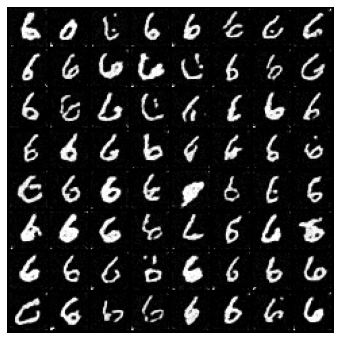

  0%|          | 0/500 [00:00<?, ?it/s]

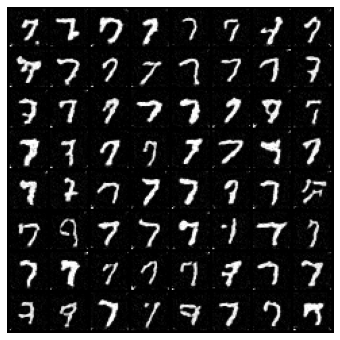

  0%|          | 0/500 [00:00<?, ?it/s]

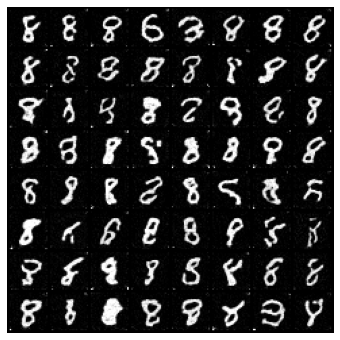

  0%|          | 0/500 [00:00<?, ?it/s]

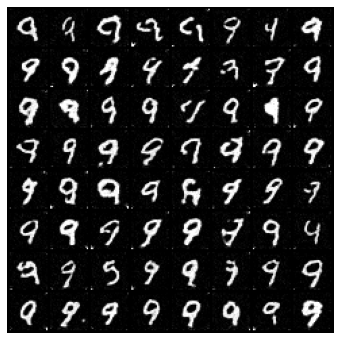

In [ ]:
save_samples_cond(score_model,"_res") # model with res connection

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


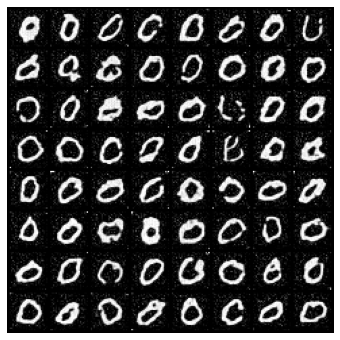

  0%|          | 0/250 [00:00<?, ?it/s]

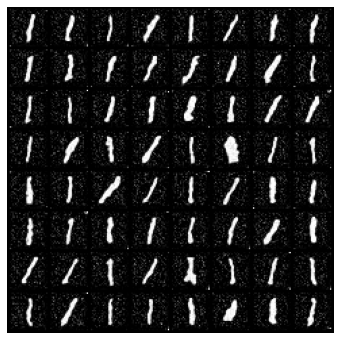

  0%|          | 0/250 [00:00<?, ?it/s]

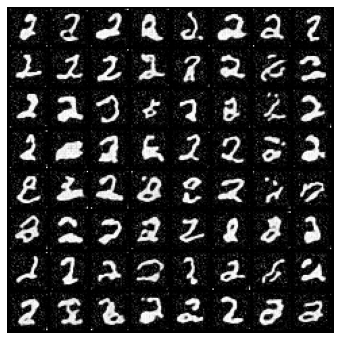

  0%|          | 0/250 [00:00<?, ?it/s]

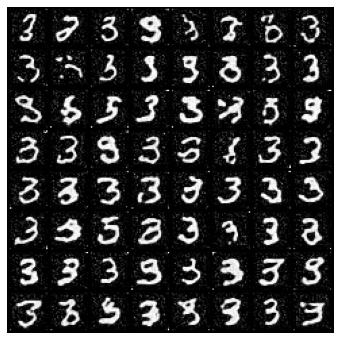

  0%|          | 0/250 [00:00<?, ?it/s]

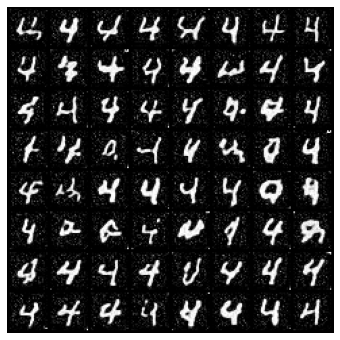

  0%|          | 0/250 [00:00<?, ?it/s]

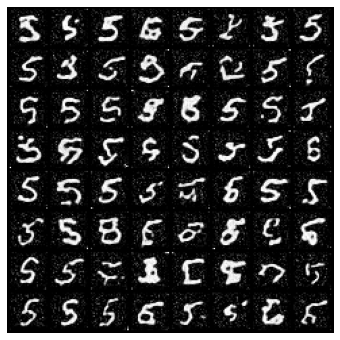

  0%|          | 0/250 [00:00<?, ?it/s]

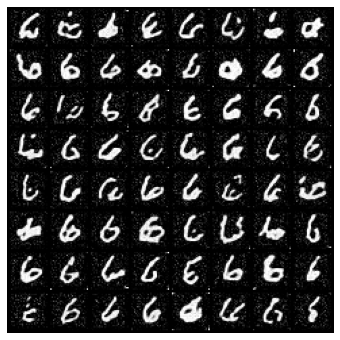

  0%|          | 0/250 [00:00<?, ?it/s]

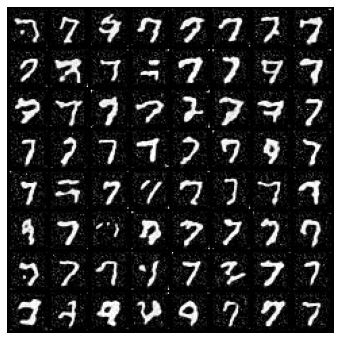

  0%|          | 0/250 [00:00<?, ?it/s]

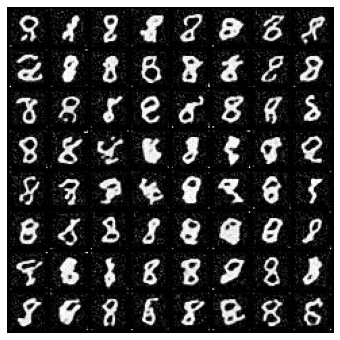

  0%|          | 0/250 [00:00<?, ?it/s]

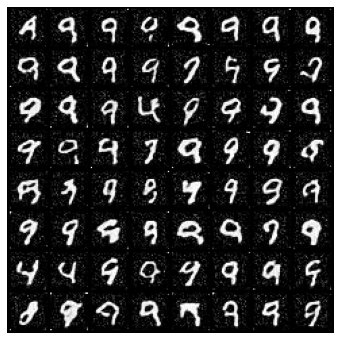

In [ ]:
save_samples_cond(score_model) # model without res connection

--------------------

## 5. Latent space diffusion using an autoencoder

Finally, we get to one of the most important contributions of [Rombach et al.](https://ommer-lab.com/research/latent-diffusion-models/), the paper behind Stable Diffusion! Instead of diffusing in pixel space (i.e. corrupting and denoising each pixel of an image), we can try diffusing in some kind of *latent space*. 

This has a few advantages. An obvious one is speed: compressing images before doing forward/reverse diffusion on them makes both generation and training faster. Another advantage is that the latent space, if carefully chosen, may be a more natural or interpretable space for working with images. For example, given a set of pictures of heads, perhaps some latent direction corresponds to head direction. 

If we do not have any a priori bias towards one latent space or another, we can just throw an autoencoder at the problem and hope it comes up with something appropriate. 

In this section, **we will use an autoencoder to compress MNIST images to a smaller scale**, and glue this to the rest of our diffusion pipeline.

### Defining the autoencoder

**Complete the missing part of the autoencoder's forward function**. Note that what an autoencoder does is first 'encode' an image into some latent representation, and then 'decode' an image from that latent representation. 

*Hint: You can access the encoder and decoder via `self.encoder` and `self.decoder`.*

In [ ]:
class AutoEncoder(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, channels=[4, 8, 32],):
    """Initialize a time-dependent score-based network.
    Args:
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    # Encoding layers where the resolution decreases
    self.encoder = nn.Sequential(nn.Conv2d(1, channels[0], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[0]),
                   nn.SiLU(),
                   nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=True),
                   nn.BatchNorm2d(channels[1]),
                   nn.SiLU(),
                   nn.Conv2d(channels[1], channels[2], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[2]),
                   ) #nn.SiLU(),
    self.decoder = nn.Sequential(nn.ConvTranspose2d(channels[2], channels[1], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[1]),
                   nn.SiLU(),
                   nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=True, output_padding=1),
                   nn.BatchNorm2d(channels[0]),
                   nn.SiLU(),
                   nn.ConvTranspose2d(channels[0], 1, 3, stride=1, bias=True),
                   nn.Sigmoid(),)
  
  def forward(self, x):
    ########## YOUR CODE HERE (1 line)
    output = ...
    ###################
    return output

The following code checks to see whether your autoencoder was defined properly.

In [ ]:
x_tmp = torch.randn(1,1,28,28)
print(AutoEncoder()(x_tmp).shape)
assert AutoEncoder()(x_tmp).shape == x_tmp.shape, "Check conv layer spec! the autoencoder input output shape not align"

torch.Size([1, 1, 28, 28])


### Train the autoencoder with the help of a perceptual loss

Let's train the autoencoder on MNIST images! Do this by running the cells below.

The loss could be really small ~ close to 0.01

In [ ]:
from lpips import LPIPS

In [ ]:
# Define the loss function, MSE and LPIPS 
lpips = LPIPS(net="squeeze").cuda()
loss_fn_ae = lambda x,xhat: \
    nn.functional.mse_loss(x, xhat) + \
    lpips(x.repeat(1,3,1,1), x_hat.repeat(1,3,1,1)).mean()

In [ ]:
ae_model = AutoEncoder([4, 4, 4]).cuda()
n_epochs =   50  #@param {'type':'integer'}
## size of a mini-batch
batch_size =  2048   #@param {'type':'integer'}
## learning rate
lr=10e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

optimizer = Adam(ae_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)    
    z = ae_model.encoder(x)
    x_hat = ae_model.decoder(z)
    loss = loss_fn_ae(x, x_hat) #loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  print('{} Average Loss: {:5f}'.format(epoch, avg_loss / num_items))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(ae_model.state_dict(), 'ckpt_ae.pth')

Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/squeeze.pth


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/50 [00:00<?, ?it/s]

0 Average Loss: 0.576265
1 Average Loss: 0.377764
2 Average Loss: 0.277722
3 Average Loss: 0.213910
4 Average Loss: 0.167607
5 Average Loss: 0.137186
6 Average Loss: 0.114799
7 Average Loss: 0.097592
8 Average Loss: 0.084385
9 Average Loss: 0.073949
10 Average Loss: 0.065258
11 Average Loss: 0.057647
12 Average Loss: 0.050750
13 Average Loss: 0.044420
14 Average Loss: 0.038747
15 Average Loss: 0.033954
16 Average Loss: 0.030010
17 Average Loss: 0.026624
18 Average Loss: 0.023933
19 Average Loss: 0.021834
20 Average Loss: 0.020204
21 Average Loss: 0.018909
22 Average Loss: 0.017843
23 Average Loss: 0.016944
24 Average Loss: 0.016180
25 Average Loss: 0.015518
26 Average Loss: 0.014946
27 Average Loss: 0.014435
28 Average Loss: 0.013976
29 Average Loss: 0.013558
30 Average Loss: 0.013188
31 Average Loss: 0.012850
32 Average Loss: 0.012540
33 Average Loss: 0.012256


KeyboardInterrupt: ignored

In [ ]:
x_hat.shape

torch.Size([2048, 1, 28, 28])

The below cell visualizes the results. The autoencoder's output should look almost identical to the original images.

In [ ]:
#@title Visualize trained autoencoder
ae_model.eval()
x, y = next(iter(data_loader))
x_hat = ae_model(x.to(device)).cpu()
plt.figure(figsize=(6,6.5))
plt.axis('off')
plt.imshow(make_grid(x[:64,:,:,:].cpu()).permute([1,2,0]), vmin=0., vmax=1.)
plt.title("Original")
plt.show()

plt.figure(figsize=(6,6.5))
plt.axis('off')
plt.imshow(make_grid(x_hat[:64,:,:,:].cpu()).permute([1,2,0]), vmin=0., vmax=1.)
plt.title("AE Reconstructed")
plt.show()

NameError: ignored

### Create latent state dataset

Let's use our autoencoder to convert MNIST images into a latent space representation. We will use these compressed images to train our diffusion generative model.

In [ ]:
batch_size = 4096
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
ae_model.requires_grad_(False)
ae_model.eval()
zs = []
ys = []
for x, y in tqdm(data_loader):
  z = ae_model.encoder(x.to(device)).cpu()
  zs.append(z)
  ys.append(y)

zdata = torch.cat(zs, )
ydata = torch.cat(ys, )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
print(zdata.shape)
print(ydata.shape)
print(zdata.mean(), zdata.var())

torch.Size([60000, 4, 10, 10])
torch.Size([60000])
tensor(-0.0616) tensor(0.9521)


In [ ]:
from torch.utils.data import TensorDataset
latent_dataset = TensorDataset(zdata, ydata)

### Transformer UNet model for Latents

Here is a U-Net (that includes self/cross-attention) similar to the one we defined before, but that this time works with compressed images instead of full-size images. You don't need to do anything here except take a look at the architecture.

In [ ]:
class Latent_UNet_Tranformer(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[4, 64, 128, 256], embed_dim=256, 
               text_dim=256, nClass=10):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(channels[0], channels[1], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[1])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[1])
    self.conv2 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[2])
    self.gnorm2 = nn.GroupNorm(4, num_channels=channels[2])
    self.attn2 = SpatialTransformer(channels[2], text_dim)
    self.conv3 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[3])
    self.gnorm3 = nn.GroupNorm(4, num_channels=channels[3])   
    self.attn3 = SpatialTransformer(channels[3], text_dim) 
    
    self.tconv3 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False, )    
    self.dense6 = Dense(embed_dim, channels[2])
    self.tgnorm3 = nn.GroupNorm(4, num_channels=channels[2])
    self.attn6 = SpatialTransformer(channels[2], text_dim)
    self.tconv2 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     # + channels[2]
    self.dense7 = Dense(embed_dim, channels[1])
    self.tgnorm2 = nn.GroupNorm(4, num_channels=channels[1])
    self.tconv1 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=1) # + channels[1]
    
    # The swish activation function
    self.act = nn.SiLU() # lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
    self.cond_embed = nn.Embedding(nClass, text_dim)
  
  def forward(self, x, t, y=None): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.time_embed(t))    
    y_embed = self.cond_embed(y).unsqueeze(1)
    # Encoding path
    ## Incorporate information from t
    h1 = self.conv1(x) + self.dense1(embed)
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    h2 = self.attn2(h2, y_embed)
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    h3 = self.attn3(h3, y_embed)

    # Decoding path
    ## Skip connection from the encoding path
    h = self.tconv3(h3) + self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.attn6(h, y_embed)
    h = self.tconv2(h + h2)
    h += self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(h + h1)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

### Training our latent diffusion model

Finally, we will put everything together, and combine our latent space representation with our fancy U-Net for learning the score function. (This may not actually work that well...but at least you can appreciate that, with all these moving parts, this becomes a hard engineering problem.)

Run the cell below to train our latent diffusion model!

In [ ]:
#@title Training Latent diffusion model

continue_training = True #@param {type:"boolean"}
if not continue_training:
  print("initilize new score model...")
  latent_score_model = torch.nn.DataParallel(
      Latent_UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn,
                  channels=[4, 16, 32, 64], ))
  latent_score_model = latent_score_model.to(device)


n_epochs =   250 #@param {'type':'integer'}
## size of a mini-batch
batch_size =  1024 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}

latent_data_loader = DataLoader(latent_dataset, batch_size=batch_size, shuffle=True, )
latent_score_model.train()
optimizer = Adam(latent_score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.5, 0.995 ** epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for z, y in latent_data_loader:
    z = z.to(device)    
    loss = loss_fn_cond(latent_score_model, z, y, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * z.shape[0]
    num_items += z.shape[0]
  scheduler.step()
  lr_current = scheduler.get_last_lr()[0]
  print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(latent_score_model.state_dict(), 'ckpt_latent_diff_transformer.pth')

  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0 Average Loss: 79.741900 lr 1.0e-04
1 Average Loss: 78.435195 lr 9.9e-05
2 Average Loss: 78.256687 lr 9.9e-05
3 Average Loss: 78.923802 lr 9.8e-05
4 Average Loss: 78.866818 lr 9.8e-05
5 Average Loss: 78.671988 lr 9.7e-05
6 Average Loss: 78.752654 lr 9.7e-05
7 Average Loss: 78.650670 lr 9.6e-05
8 Average Loss: 78.584266 lr 9.6e-05
9 Average Loss: 78.676226 lr 9.5e-05
10 Average Loss: 78.515674 lr 9.5e-05
11 Average Loss: 78.654196 lr 9.4e-05
12 Average Loss: 78.686057 lr 9.4e-05
13 Average Loss: 78.658464 lr 9.3e-05
14 Average Loss: 78.215316 lr 9.3e-05
15 Average Loss: 78.253186 lr 9.2e-05
16 Average Loss: 78.219765 lr 9.2e-05
17 Average Loss: 78.056799 lr 9.1e-05
18 Average Loss: 78.698358 lr 9.1e-05
19 Average Loss: 78.507159 lr 9.0e-05
20 Average Loss: 78.948341 lr 9.0e-05
21 Average Loss: 78.129618 lr 9.0e-05
22 Average Loss: 77.991600 lr 8.9e-05
23 Average Loss: 78.630760 lr 8.9e-05
24 Average Loss: 78.335837 lr 8.8e-05
25 Average Loss: 78.107454 lr 8.8e-05
26 Average Loss: 78.80

Loss at ~55 after 600 epochs, pretty slow

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


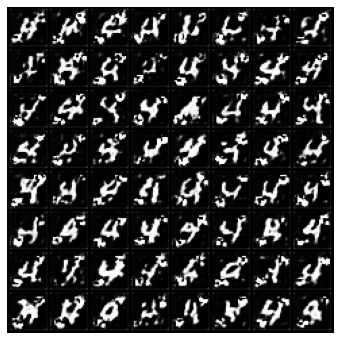

In [ ]:
digit = 4 #@param {'type':'integer'}
sample_batch_size = 64 #@param {'type':'integer'}
num_steps = 500 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
latent_score_model.eval()
## Generate samples using the specified sampler.
samples_z = sampler(latent_score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size, 
        num_steps=num_steps,
        device=device,
        x_shape=(4,10,10),
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

## Sample visualization.
decoder_samples = ae_model.decoder(samples_z).clamp(0.0, 1.0)
sample_grid = make_grid(decoder_samples, nrow=int(np.sqrt(sample_batch_size)))
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [ ]:
# play with architecturs
latent_score_model = torch.nn.DataParallel(
    Latent_UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn,
                channels=[4, 16, 32, 64], ))
latent_score_model = latent_score_model.to(device)

train_diffusion_model(latent_dataset, score_model,
                      n_epochs =   100,
                      batch_size =  1024,
                      lr=10e-4,
                      model_name="transformer_latent")

### Examine Samples

Below, we examine some samples in more detail to study the image generation quality. You may see some pretty weird stuff here.

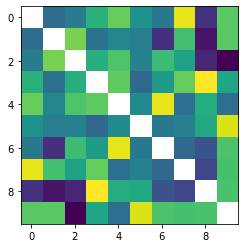

In [ ]:
cossim_mat = visualize_digit_embedding(latent_score_model.module.cond_embed.weight.data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


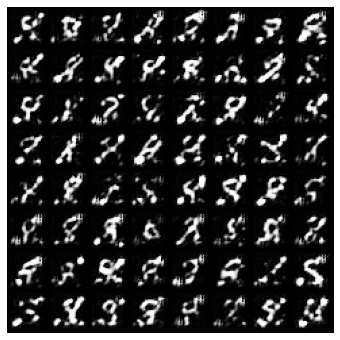

In [ ]:
digit = 8 #@param {'type':'integer'}
sample_batch_size = 64 #@param {'type':'integer'}
num_steps = 250 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
latent_score_model.eval()
## Generate samples using the specified sampler.
samples_z = sampler(latent_score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size, 
        num_steps=num_steps,
        device=device,
        x_shape=(4,10,10),
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

## Sample visualization.
decoder_samples = ae_model.decoder(samples_z).clamp(0.0, 1.0)
sample_grid = make_grid(decoder_samples, nrow=int(np.sqrt(sample_batch_size)))
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


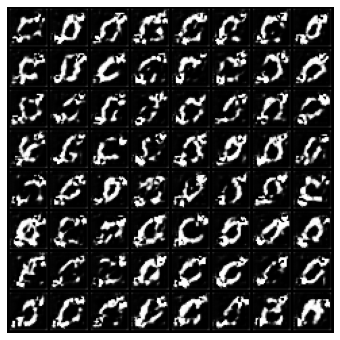

  0%|          | 0/250 [00:00<?, ?it/s]

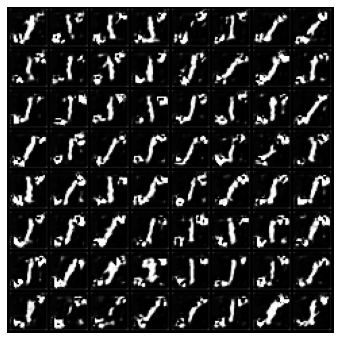

  0%|          | 0/250 [00:00<?, ?it/s]

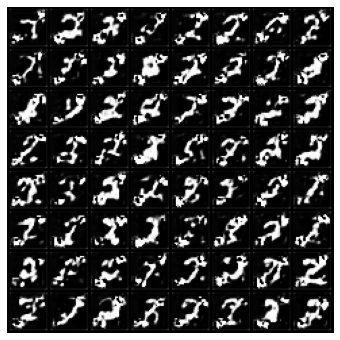

  0%|          | 0/250 [00:00<?, ?it/s]

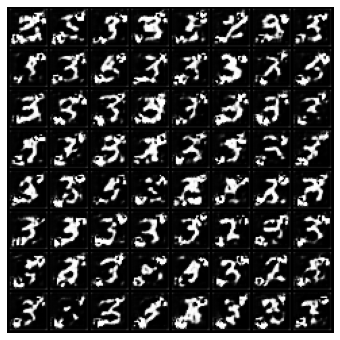

  0%|          | 0/250 [00:00<?, ?it/s]

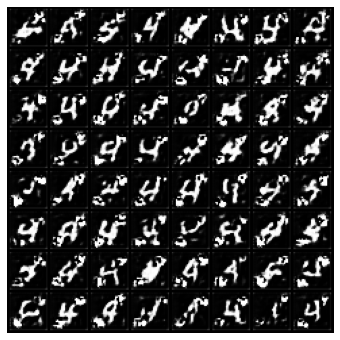

  0%|          | 0/250 [00:00<?, ?it/s]

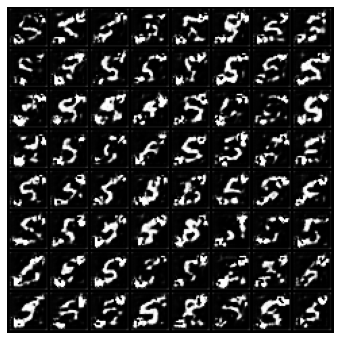

  0%|          | 0/250 [00:00<?, ?it/s]

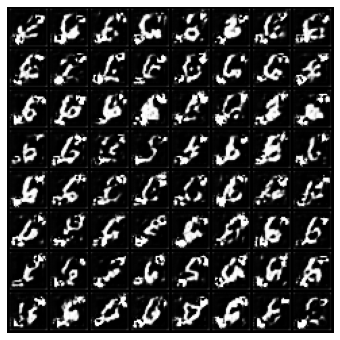

  0%|          | 0/250 [00:00<?, ?it/s]

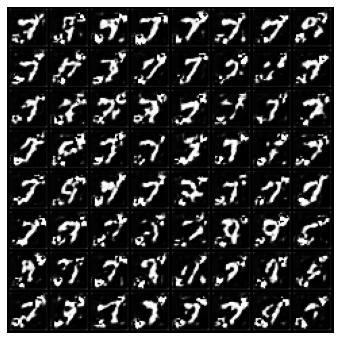

  0%|          | 0/250 [00:00<?, ?it/s]

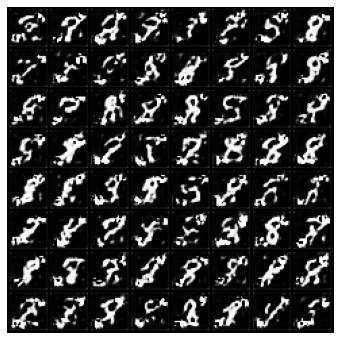

  0%|          | 0/250 [00:00<?, ?it/s]

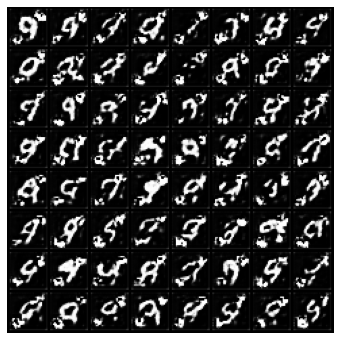

In [ ]:
def save_samples_latents(latent_score_model, suffix):
  for digit in range(10):
    sample_batch_size = 64 #@param {'type':'integer'}
    num_steps = 250 #@param {'type':'integer'}
    sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
    latent_score_model.eval()
    ## Generate samples using the specified sampler.
    samples_z = sampler(latent_score_model, 
            marginal_prob_std_fn,
            diffusion_coeff_fn, 
            sample_batch_size, 
            num_steps=num_steps,
            device=device,
            x_shape=(4,10,10),
            y=digit*torch.ones(sample_batch_size, dtype=torch.long))

    ## Sample visualization.
    decoder_samples = ae_model.decoder(samples_z).clamp(0.0, 1.0)
    sample_grid = make_grid(decoder_samples, nrow=int(np.sqrt(sample_batch_size)))
    sample_np = sample_grid.permute(1, 2, 0).cpu().numpy()
    plt.imsave(f"latent_diffusion{suffix}_digit%d.png"%digit, sample_np,)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_np, vmin=0., vmax=1.)
    plt.show()
save_samples_latents(latent_score_model, "_restanh")

## Save your progress!

In [ ]:
%cp ckpt*.pth /content/drive/MyDrive/MLFS_StableDiffusionDemo

In [ ]:
!du -sh ckpt*.pth

16K	ckpt_ae.pth
1.2M	ckpt_latent_diff_transformer.pth


In [ ]:
# %mkdir /content/drive/MyDrive/MLFS_StableDiffusionDemo/imgs
%cp  *.png /content/drive/MyDrive/MLFS_StableDiffusionDemo/imgs